In [1]:
# To allow importing of packages in two directories up
import sys
sys.path.append("../..")

# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.metrics import mutual_info_score
from tqdm.auto import tqdm
import scipy.stats as sc


#from core.wca import wca_mean
np.random.seed(21)

In [2]:
import pandas as pd
import io
import requests

In [3]:
def read_HousingData():
    """
        Function to read boston housing data. 
    """
    from sklearn.datasets import load_boston
    boston_dataset = load_boston()
    df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
    df['target']=boston_dataset.target
    y=df['target']
    X=df.drop('target',axis=1)
    return (X,y,df)

In [4]:
# Setting a sci-kit learn standard dataset
data = datasets.load_iris()

# Setting the number of clusters
k=2

# Number of columns to show
col_num = 4

def get_data(data):
    """
        Function to retreive the data and pass it into the format we need
    """
    y = data.target
    columns=data.feature_names
    X = data.data
    df=pd.DataFrame(X,columns=columns)
    df['target'] = y
    X = df.drop('target',axis=1)
    return(X,y,df)

### Random sampling

In [23]:
X, y, df= read_HousingData() 

# Splitting training and testing data
X, X_test, y, y_test = train_test_split(X,y,train_size=0.8,random_state=1)
X.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

C_random = dict()
y_random = dict()
for cluster in range(k):
    C_random[cluster] = pd.DataFrame(X[:1])
    y_random[cluster] = y[:1]

# Initializing the p-values
pval_random = dict()
for cluster in range(k):
    pval_random[cluster] = dict()
    for i in C_random[0].columns:
        pval_random[cluster][i] = list()

# Initializing the R2 scores and rmse for cluster 0
r2 = list()
rmse = list()

for i in tqdm(range(int(len(X)/k)), desc = "Iterations: "):
    for cluster in range(k):
        idx = np.random.randint(low=0,high=len(X))
        
        # For data
        C_random[cluster] = C_random[cluster].append(X.iloc[idx])
        X.drop(idx, inplace=True)
        X.reset_index(drop=True,inplace=True)
        C_random[cluster].reset_index(drop=True,inplace=True)
        
        # For target
        y_random[cluster] = y_random[cluster].append(pd.Series(y.iloc[idx]))
        #y_random[cluster].append(pd.Series(y.iloc[idx]))
        y.drop(idx, inplace=True)
        y.reset_index(drop=True,inplace=True)
        y_random[cluster].reset_index(drop=True,inplace=True)
        
        
        lr = LinearRegression()
        lr.fit(C_random[0],y_random[0])
        r2.append(lr.score(X_test,y_test))
        
        y_pred = lr.predict(X_test)
        rmse.append(mean_squared_error(y_pred=y_pred,y_true=y_test)**(1/2))
        # For p_value
        for i in C_random[0].columns:
            pval_random[cluster][i].append(sc.ks_2samp(C_random[cluster][i],df.drop('target',axis=1)[i])[1])

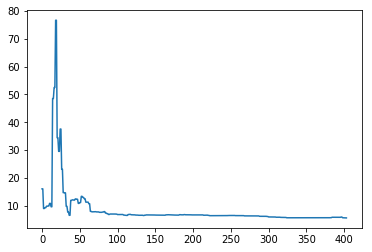

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(rmse)
plt.show()

### WCA

In [ ]:
X, y, df= read_HousingData() 
X, X_test, y, y_test = train_test_split(X,y,train_size=0.8,random_state=1)
X.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

def wca_mean(X, k, df):
    """
        Implementes the WCA algorithm which maximizes the entropy with respect to the mean of the clusters

        X = Dataframe
        k = number of clusters
    """
    

    # Intializing the clusters	
    C = dict()
    for cluster in range(k):
        C[cluster] = pd.DataFrame()

    # Calculating the mean vector
    mean_vector = X.mean()

    # Choosing the seed points based on the minimum distance from the mean vector
    X['dist_mean'] = X.apply(lambda x: np.linalg.norm(np.asarray(x)- np.asarray(mean_vector)), axis=1)
    dist_means = X.sort_values(by='dist_mean')
    
    # Dropping the the datapoints which have already been assigned as seed
    idx_to_drop = dist_means.index[:k]
    dist_means.reset_index(drop=True,inplace=True)
    X.drop('dist_mean',axis=1,inplace=True)
    X.drop(idx_to_drop, inplace=True)

    # Assigning seed points to the clusters
    mu = list()
    for cluster in range(k):
        C[cluster] = C[cluster].append(dist_means.iloc[cluster].drop('dist_mean'))
        mu.append(C[cluster].mean())
    
    # Running the algorithm	
    
    # Initializing the p-value list which would be used for plotting
    pval = dict()

    for cluster in range(k):
        pval[cluster] = dict()
        for i in C[0].columns:
            pval[cluster][i] = list()

    # Algorithm
    for i in tqdm(range(int(len(X)/k)), desc='Iterations: '):
        for cluster in range(k):

            # Calculating the distances from the mean vector of eaimportch cluster (in Descending order)
            X['dist_mean'] = X.apply(lambda x: np.linalg.norm(np.asarray(x)- np.asarray(mu[cluster])), axis=1)
            dist_means = X.sort_values(by='dist_mean', ascending=False)
            idx_to_drop = dist_means.index[0]
            dist_means.reset_index(drop=True,inplace=True)
            X.drop('dist_mean',axis=1,inplace=True)

            # Assigning the top value to the cluster
            C[cluster] = C[cluster].append(dist_means.iloc[0].drop('dist_mean'))
            C[cluster] = C[cluster].reset_index(drop=True)
            
            # Updating means of each cluster
            mu[cluster] = C[cluster].mean()

            # Remove datapoint from X?
            X.drop(idx_to_drop,inplace=True)
            
            for i in C[0].columns:
                pval[cluster][i].append(sc.ks_2samp(C[cluster][i],df.drop('target',axis=1)[i])[1])

    return(C,pval)



# Running the wca_mean function
C, pval,df_clus = wca_mean(X, k, df)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train=df_clus[0]
Y_train=X_train['target']
X_train.drop('target',axis=1,inplace=True)

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

In [ ]:
X_test=df_clus[1]
Y_test=X_test['target']
X_test.drop('target',axis=1,inplace=True)
yp=lin_model.predict(X_test)

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_val = rmse(yp, Y_test)
print("rms error is: " + str(rmse_val))

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(predictions, targets,color='g')


plt.show()

### Plotting the result

In [ ]:
fig, axes = plt.subplots(k, len(C[0].columns[:col_num]), figsize=(15,k*2.5))

# Plotting the KS p-value
for cluster in range(k):
    for i,j in enumerate(C[0].columns[:col_num]):
        axes[cluster, i].plot(pval_random[cluster][j], marker='.',color="Blue")
        axes[cluster, i].plot(pval[cluster][j], marker='+',color='Black')
        axes[cluster, i].legend(['Random','WCA'])
        

# Setting columns headers
for ax, col in zip(axes[0], C[0].columns[:col_num]):
    ax.set_title(col)

# Setting row titles
for ax, row in zip(axes[:,0], range(k)):
    ax.set_ylabel("Cluster {} ".format(row), rotation=90, size='large')
        
plt.tight_layout()
plt.show()      